<a href="https://colab.research.google.com/github/marissafujimoto/catmap/blob/label-transfer-poc/catmap_rfc_classifier_poc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Description of Notebook

In this notebook we demonstrate the ability to embed new data using an existing scvi model. Then show that a random forest classifier can be used to predict labels learned from the training data.

## Dependencies and Settings

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

INFO     scvi-colab: Installing scvi-tools.                                                                        
INFO     scvi-colab: Install successful. Testing import.                                                           


/usr/local/lib/python3.11/dist-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/usr/local/lib/python3.11/dist-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [42]:
import os
import tempfile

import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import seaborn as sns
import torch
from scipy.io import mmread
from sklearn.ensemble import RandomForestClassifier
import joblib

In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0


Last run with scvi-tools version: 1.3.0


In [4]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
output_dir = "/content/drive/MyDrive/catmap"

 # Loading Model and Data

 The model must be loaded with data. Currently there is no way to do these separately.

In [7]:
adata = sc.read(os.path.join(output_dir, "adata-train.h5ad"))

In [8]:
adata

AnnData object with n_obs × n_vars = 223404 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Percent_mt', 'Patient', 'Gender', 'Subtype', 'Stage', 'seurat_clusters', 'Study', 'Cell_Cluster_level1', 'Cell_Cluster_level2', 'validation_original_annotation', 'id', 'predicted.celltypel1.score', 'predicted.celltypel1', 'predicted.celltypel2.score', 'predicted.celltypel2', '_scvi_batch', '_scvi_labels', 'source'
    var: 'features', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'Cell_Cluster_level1_colors', 'Patient_colors', 'Study_colors', '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap', 'X_umap.ref'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [21]:
adata_transfer = sc.read(os.path.join(output_dir, "adata-test.h5ad"))

In [22]:
adata_transfer

AnnData object with n_obs × n_vars = 1207 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Percent_mt', 'Patient', 'Gender', 'Subtype', 'Stage', 'seurat_clusters', 'Study', 'Cell_Cluster_level1', 'Cell_Cluster_level2', 'validation_original_annotation', 'id', 'predicted.celltypel1.score', 'predicted.celltypel1', 'predicted.celltypel2.score', 'predicted.celltypel2', 'source'
    var: 'features'
    obsm: 'X_umap', 'X_umap.ref'
    layers: 'counts'

In [23]:
scvi_model = scvi.model.SCVI.load(os.path.join(output_dir, "nsclc-scvi-model"), adata)
scvi_model.is_trained = True

INFO     File /content/drive/MyDrive/catmap/nsclc-scvi-model/model.pt already downloaded                           


In [24]:
scvi_model_transfer = scvi.model.SCVI.load(os.path.join(output_dir, "nsclc-scvi-model"), adata_transfer)
scvi_model_transfer.is_trained = True

INFO     File /content/drive/MyDrive/catmap/nsclc-scvi-model/model.pt already downloaded                           


/usr/local/lib/python3.11/dist-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


## Embedding New Data

`adata_transfer` contains data not seen in the training set. Let's see if we can embed it with the loaded model.

In [25]:
latent = scvi_model_transfer.get_latent_representation()
adata_transfer.obsm["X_scVI"] = latent

In [29]:
adata.obs["source"] = "train"
adata_transfer.obs["source"] = "test"
adata_concat = anndata.concat([adata, adata_transfer])

In [30]:
adata_concat

AnnData object with n_obs × n_vars = 224611 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Percent_mt', 'Patient', 'Gender', 'Subtype', 'Stage', 'seurat_clusters', 'Study', 'Cell_Cluster_level1', 'Cell_Cluster_level2', 'validation_original_annotation', 'id', 'predicted.celltypel1.score', 'predicted.celltypel1', 'predicted.celltypel2.score', 'predicted.celltypel2', '_scvi_batch', '_scvi_labels', 'source'
    obsm: 'X_umap', 'X_umap.ref', 'X_scVI'
    layers: 'counts'

In [31]:
sc.pp.neighbors(adata_concat, n_neighbors=15, use_rep="X_scVI")
sc.tl.umap(adata_concat)

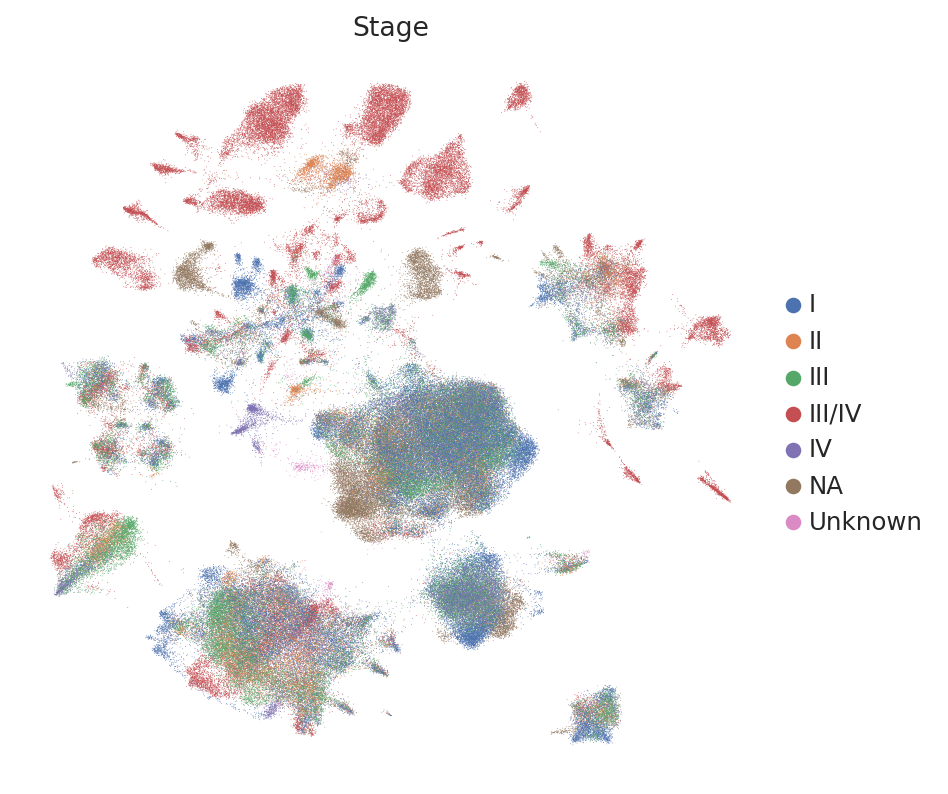

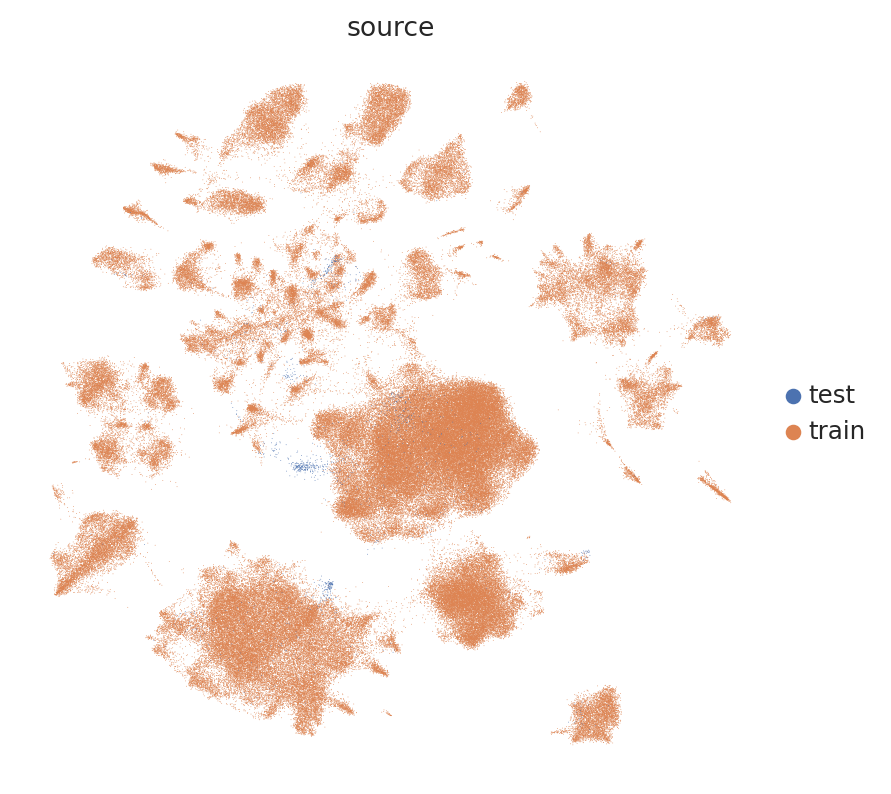

In [32]:
sc.pl.umap(
    adata_concat,
    color=["Stage"],
    frameon=False,
    ncols=1
)
sc.pl.umap(
    adata_concat,
    color=["source"],
    frameon=False,
    ncols=1,
)

## Classifying Using Random Forest

Using the embedding vector we can train a random forest classifier on any observation field. For this example we'll try to predict cell cluster 1.

In [34]:
rfc = RandomForestClassifier()
rfc.fit(adata.obsm["X_scVI"], adata.obs["Cell_Cluster_level1"].values)

RandomForestClassifier()

In [36]:
adata_transfer.obs["predicted_Cell_Cluster_level1"] = rfc.predict(adata_transfer.obsm["X_scVI"])

In [37]:
adata.obs["predicted_Cell_Cluster_level1"] = adata.obs["Cell_Cluster_level1"]
adata_predict_concat = anndata.concat([adata, adata_transfer])

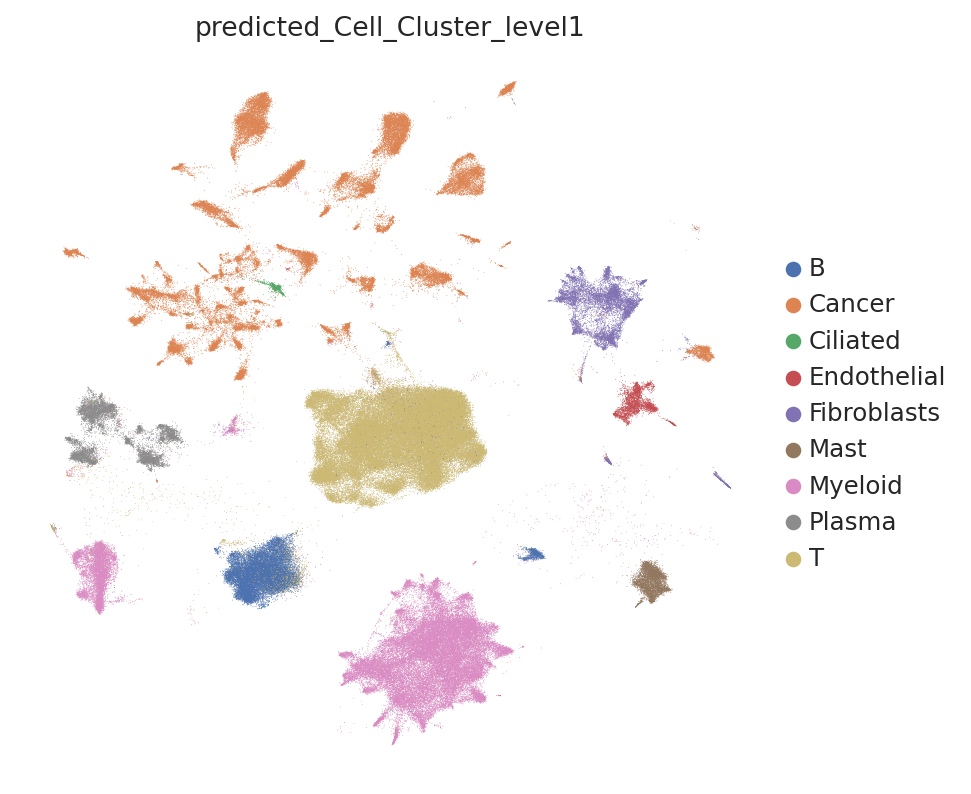

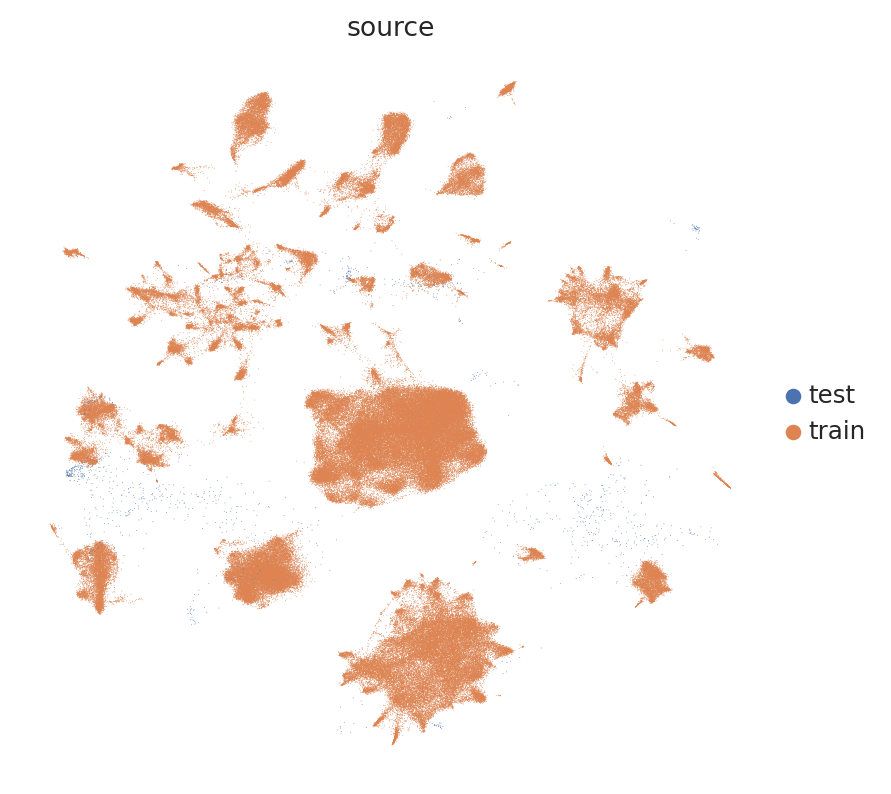

In [41]:
sc.pl.umap(
    adata_predict_concat,
    color=["predicted_Cell_Cluster_level1"],
    frameon=False,
    ncols=1,
)
sc.pl.umap(
    adata_predict_concat,
    color=["source"],
    frameon=False,
    ncols=1,
)

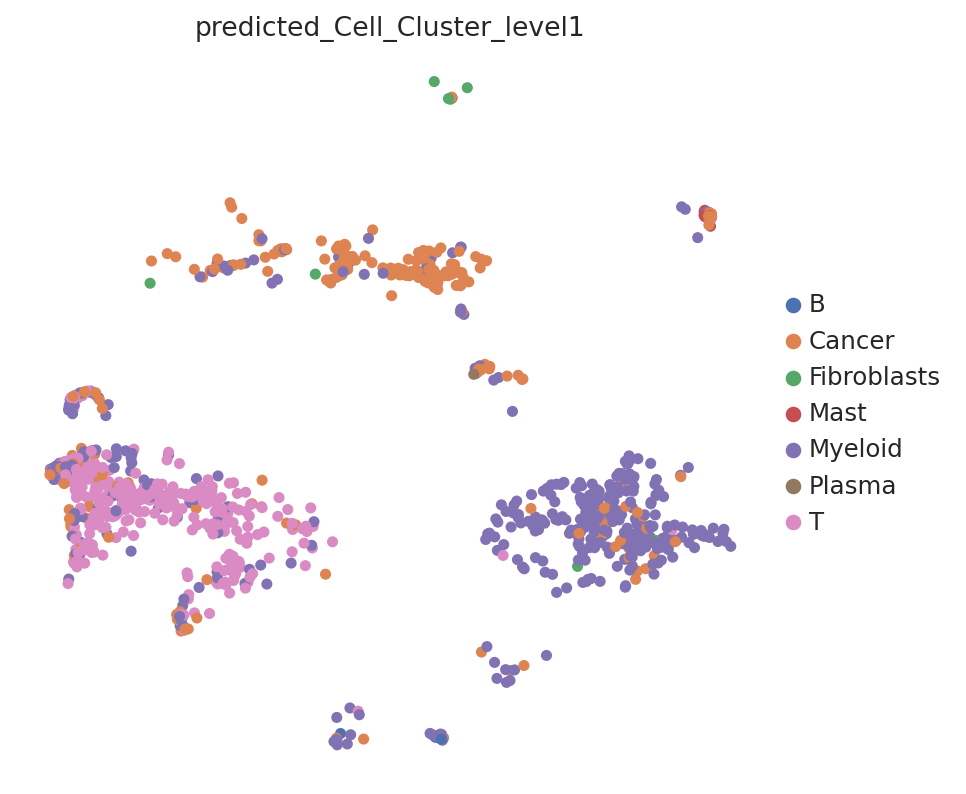

In [40]:
sc.pl.umap(
    adata_transfer,
    color=["predicted_Cell_Cluster_level1"],
    frameon=False,
    ncols=1,
)

 ## Classifying Cancer Stage with RFC

In [45]:
rfc_cancer_stage = RandomForestClassifier()
rfc_cancer_stage.fit(adata.obsm["X_scVI"], adata.obs["Stage"].values)

RandomForestClassifier()

In [46]:
adata_transfer.obs["predicted_Stage"] = rfc_cancer_stage.predict(adata_transfer.obsm["X_scVI"])

In [47]:
adata.obs["predicted_Stage"] = adata.obs["Stage"]
adata_predict_stage_concat = anndata.concat([adata, adata_transfer])

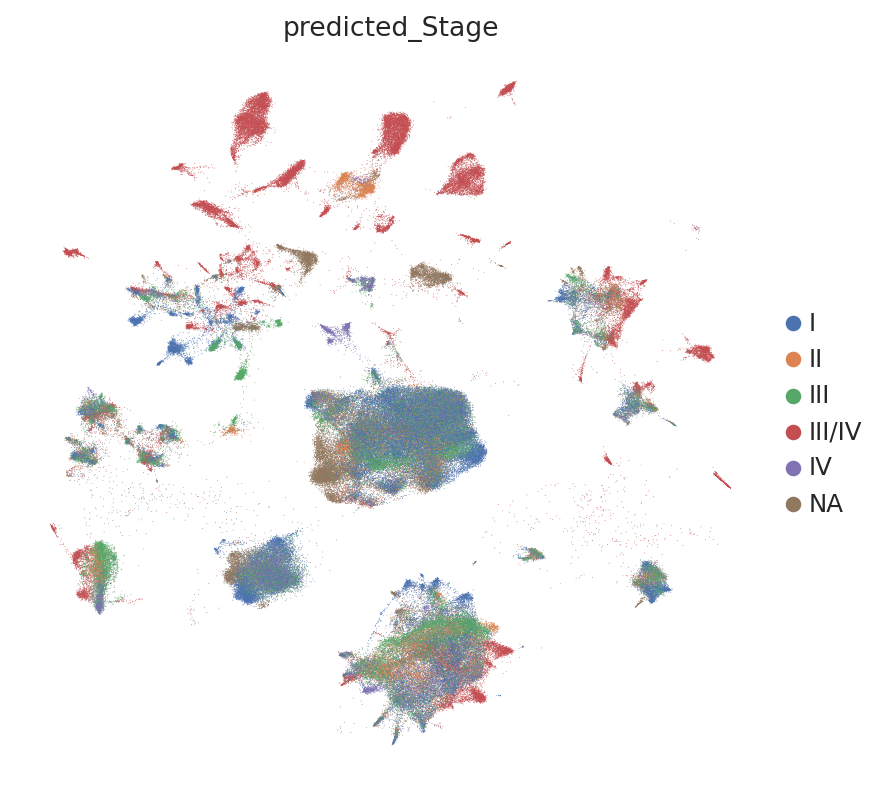

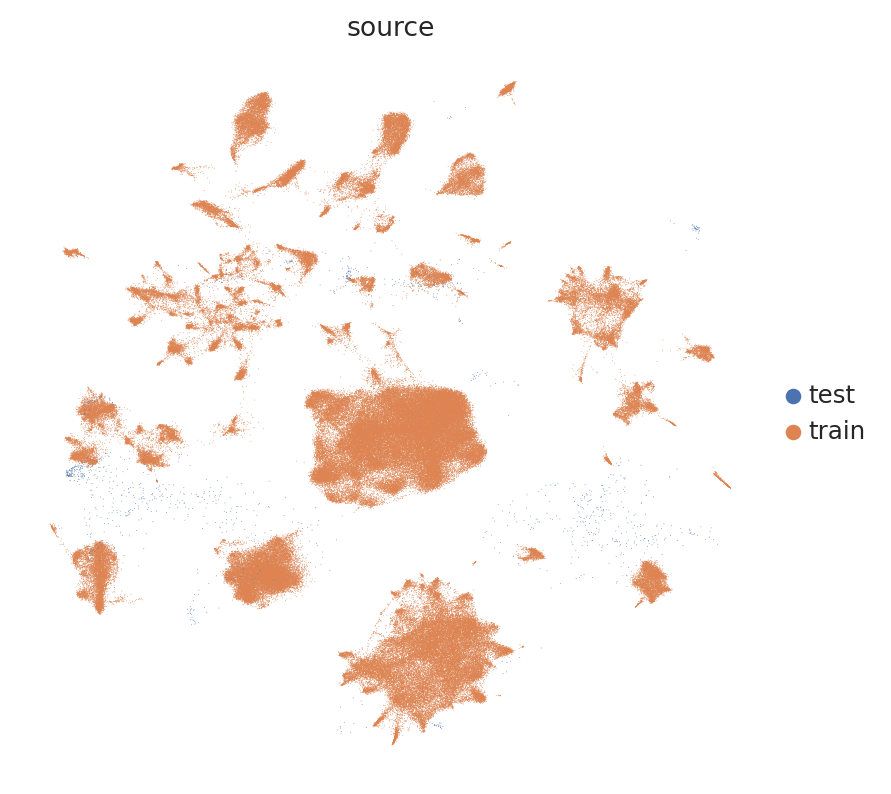

In [48]:
sc.pl.umap(
    adata_predict_stage_concat,
    color=["predicted_Stage"],
    frameon=False,
    ncols=1,
)
sc.pl.umap(
    adata_predict_stage_concat,
    color=["source"],
    frameon=False,
    ncols=1,
)

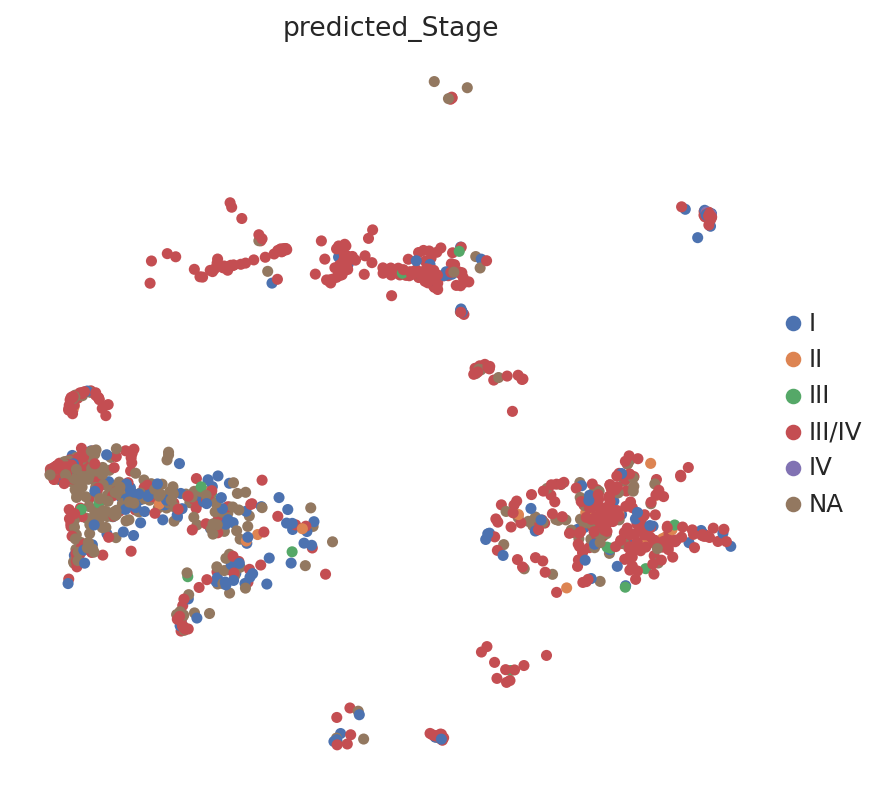

In [49]:
sc.pl.umap(
    adata_transfer,
    color=["predicted_Stage"],
    frameon=False,
    ncols=1,
)

## Saving the RFC Models

In [51]:
joblib.dump(rfc, os.path.join(output_dir, "cc1_rfc.joblib"), compress=3)

['/content/drive/MyDrive/catmap/cc1_rfc.joblib']

In [52]:
joblib.dump(rfc_cancer_stage, os.path.join(output_dir, "stage_rfc.joblib"), compress=3)

['/content/drive/MyDrive/catmap/stage_rfc.joblib']